In [1]:
import numpy as np 
import scipy as sp
import scipy.sparse as spsp
import scipy.sparse.linalg as spsplin
import matplotlib.pyplot as plt

## Partie 1. (GMRES)

1. 

In [2]:
def Arnoldi(A, V, H):
    n, p = np.shape(V)
    Vp = np.zeros((n, p + 1))
    Hp = np.zeros((p + 1, p))

    if H.size != 0:
        Hp[:-1, :-1] = H[:, :]
    Vp[:, :-1] = V[:, :]

    Av = A @ V[:, -1]
    for i in range(p):
        Hp[i, -1] = np.dot(Vp[:, i], Av)
    wp = Av - Vp[:, :-1] @ Hp[:-1, -1]
    Hp[-1, -1] = np.linalg.norm(wp)
    Vp[:, -1] = wp / Hp[-1, -1]

    return Vp, Hp

2. 

In [3]:
def gmres(A, b, xexact, tol=1e-6, maxit=None):
    n = len(b)
    x0 = np.zeros(n)          
    r0 = b - A @ x0
    resnorm0 = np.linalg.norm(r0)

    V = np.zeros((n, 1))
    V[:, 0] = r0 / resnorm0
    H = np.zeros((1, 0))

    error_list = []
    residual_list = []

    resnorm = 1.0
    it = 0
    maxit = maxit or n
    while (resnorm >= tol) and (it < maxit):    
        it += 1

        V, H = Arnoldi(A, V, H)

        # Solve least squares problem using QR decomposition
        e1 = np.zeros(H.shape[0])
        e1[0] = resnorm0
        Q, R = np.linalg.qr(H)
        y = np.linalg.solve(R, Q.T @ e1)
        x = x0 + V[:, :-1] @ y

        # Calculate relative error and residual norm
        resnorm = np.linalg.norm(b - A @ x) / resnorm0
        error = np.linalg.norm(x - xexact) / np.linalg.norm(xexact)

        error_list.append(error)
        residual_list.append(resnorm)

    return x, error_list, residual_list

3. 

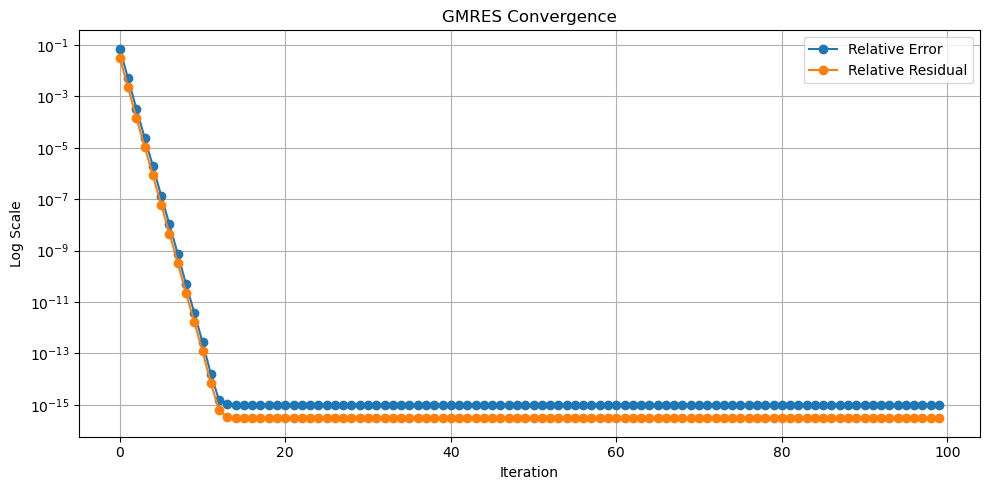

In [4]:
n = 100
A = np.diag(2 * np.ones(n)) + 0.5 * np.random.rand(n, n) / np.sqrt(n)
b = np.ones(n)
x_exact = np.linalg.solve(A, b)

x_approx, error_list, residual_list = gmres(A, b, x_exact, tol=1e-18)

plt.figure(figsize=(10, 5))
plt.semilogy(error_list, marker='o', label='Relative Error')
plt.semilogy(residual_list, marker='o', label='Relative Residual')
plt.xlabel('Iteration')
plt.ylabel('Log Scale')
plt.title('GMRES Convergence')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


4. 

In [5]:
def gmres_restart(A, b, xexact, restart=10, max_iter=100, tol=1e-6):
    n = len(b)
    x = np.zeros(n)
    errors = []
    residuals = []
    total_iter = 0
    r = b - A @ x
    beta = np.linalg.norm(r)

    while total_iter < max_iter and beta > tol * np.linalg.norm(b):
        # 初始化 Krylov 子空间和 Hessenberg 矩阵
        V = (r / beta).reshape(-1, 1)
        H = np.zeros((0, 0))

        for k in range(restart):
            total_iter += 1

            V, H = Arnoldi(A, V, H)

            m = H.shape[0]
            e1 = np.zeros((m, 1))
            e1[0] = beta
            Q, R = np.linalg.qr(H)
            y = np.linalg.solve(R, Q.T @ e1)
            x_new = x + V[:, :-1] @ y.flatten()

            error = np.linalg.norm(xexact - x_new) / np.linalg.norm(xexact)
            rk = b - A @ x_new
            residual = np.linalg.norm(rk) / np.linalg.norm(b)

            errors.append(error)
            residuals.append(residual)

            if residual < tol:
                print(f"GMRES with restart converged at iteration {total_iter}")
                return x_new, errors, residuals

        x = x_new
        r = b - A @ x
        beta = np.linalg.norm(r)

    return x, errors, residuals

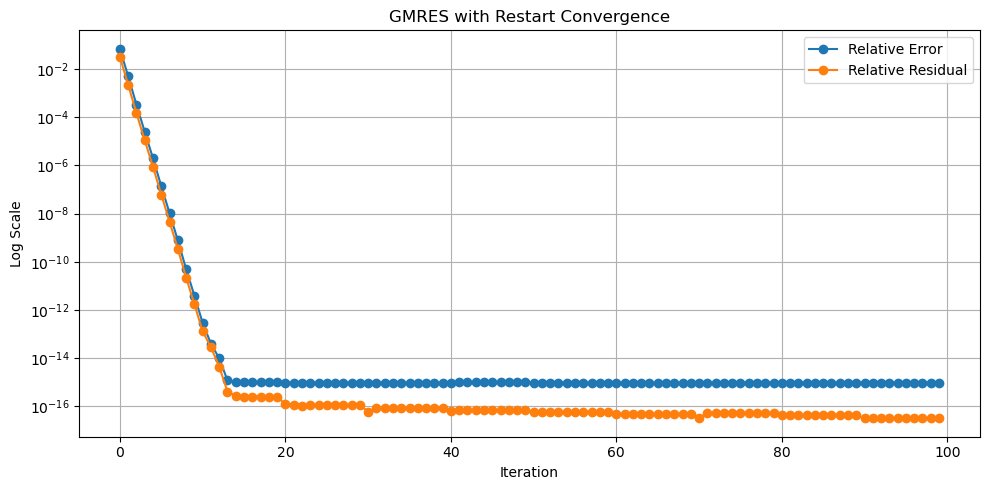

In [6]:
# 重启 GMRES
xk, errors, residuals = gmres_restart(A, b, x_exact, restart=10, max_iter=100, tol=1e-18)

plt.figure(figsize=(10, 5))
plt.semilogy(errors, marker='o', label='Relative Error')
plt.semilogy(residuals, marker='o', label='Relative Residual')
plt.xlabel('Iteration')
plt.ylabel('Log Scale')
plt.title('GMRES with Restart Convergence')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Partie 2. (Gradient Conjugué) 

5. 

In [7]:
def gradient_conjugue(A, b, xexact):
    n = len(b)
    x = np.zeros(n)  # 初始解 x_0

    r = b - A @ x  # 初始残差 r_0
    d = r.copy()    # 初始搜索方向 d_0

    err_list = []
    resnorm_list = []

    resnorm0 = np.linalg.norm(r)
    if resnorm0 == 0:
        return x, [0], [0]

    resnorm = resnorm0
    maxit = n  # 最大迭代次数
    it = 0

    while resnorm / resnorm0 > 1e-6 and it < maxit:
        it += 1

        Ad = A @ d
        r_dot_r = np.dot(r, r)
        alpha = r_dot_r / np.dot(d, Ad)

        # 更新解
        x = x + alpha * d

        # 更新残差
        r_new = r - alpha * Ad

        # 计算误差和残差范数
        resnorm = np.linalg.norm(r_new)
        err = np.linalg.norm(x - xexact) / np.linalg.norm(xexact)

        err_list.append(err)
        resnorm_list.append(resnorm / resnorm0)

        # 更新搜索方向
        beta = np.dot(r_new, r_new) / r_dot_r
        d = r_new + beta * d

        # 准备下一次迭代
        r = r_new

    return x, err_list, resnorm_list

6. 

In [8]:
d = 50  # 可以调整矩阵大小
n = d**2

# 构造稀疏矩阵 B
diagonals = [
    4.0 * np.ones(n),            # 主对角线
    -1.0 * np.ones(n - 1),       # 上一对角线
    -1.0 * np.ones(n - 1),       # 下一对角线
    -1.0 * np.ones(n - d),       # d 上的对角线
    -1.0 * np.ones(n - d)        # d 下的对角线
]
offsets = [0, 1, -1, d, -d]
B = spsp.diags(diagonals, offsets, shape=(n, n), format='csr')

/tmp/ipykernel_70332/20982674.py:15: DeprecationWarning: 'scipy.sparse.linalg.gmres' keyword argument `tol` is deprecated in favor of `rtol` and will be removed in SciPy v1.14.0. Until then, if set, it will override `rtol`.
  x_gmres, info = gmres(B, b, tol=1e-6)


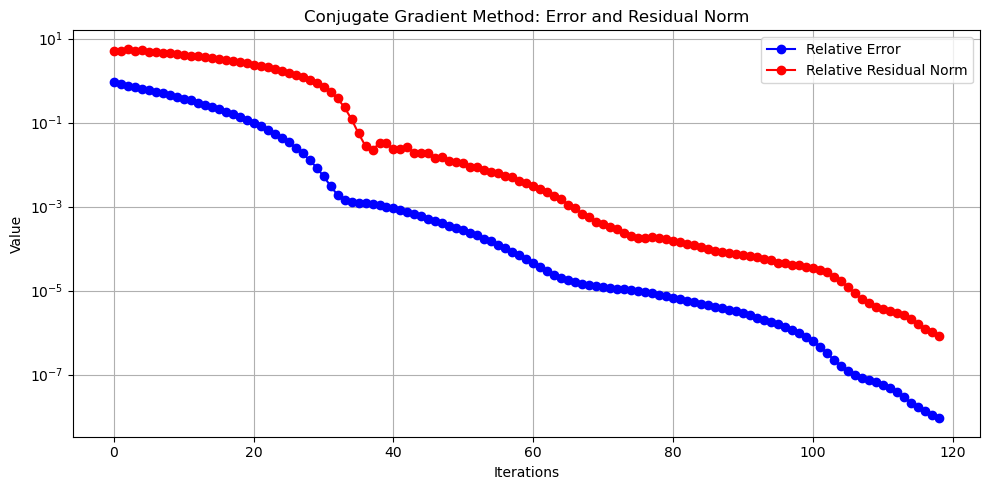

共轭梯度法计算时间：0.0053 秒
GMRES 方法计算时间：0.1399 秒


In [9]:
import time
from scipy.sparse.linalg import gmres

# 生成右端项 b 和精确解 x_exact
b = np.ones(n)
x_exact = spsp.linalg.spsolve(B, b)  # 使用稀疏求解器

# 使用共轭梯度法求解
start_time = time.time()
x_cg, err_list_cg, resnorm_list_cg = gradient_conjugue(B, b, x_exact)
cg_time = time.time() - start_time

# 使用 GMRES 方法求解
start_time = time.time()
x_gmres, info = gmres(B, b, tol=1e-6)
gmres_time = time.time() - start_time

# 计算 GMRES 方法的误差和残差
err_list_gmres = [np.linalg.norm(x_gmres - x_exact) / np.linalg.norm(x_exact)]
resnorm_list_gmres = [np.linalg.norm(b - B @ x_gmres) / np.linalg.norm(b - B @ np.zeros(n))]

# 绘制误差和残差
plt.figure(figsize=(10, 5))

# 共轭梯度法的相对误差
# 共轭梯度法的相对残差范数
plt.semilogy(err_list_cg, marker='o', label='Relative Error', color='blue')
plt.semilogy(resnorm_list_cg, marker='o', label='Relative Residual Norm', color='red')

plt.title('Conjugate Gradient Method: Error and Residual Norm')
plt.xlabel('Iterations')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 输出计算时间
print(f"共轭梯度法计算时间：{cg_time:.4f} 秒")
print(f"GMRES 方法计算时间：{gmres_time:.4f} 秒")


## Partie 3. (Préconditionnement)

7. 

In [10]:
def gmres_preconditioned(A, b, M, x_exact, tol=1e-6, max_iter=None):
    n = len(b)
    x0 = np.zeros(n)
    r0 = b - A @ x0
    z0 = np.linalg.solve(M, r0)
    beta = np.linalg.norm(z0)

    V = (z0 / beta).reshape(-1, 1)
    H = np.zeros((0, 0))

    error_list = []
    residual_list = []

    res_norm = beta
    iter_count = 0
    max_iter = max_iter or n

    while res_norm >= tol and iter_count < max_iter:
        iter_count += 1

        # Arnoldi过程生成Krylov子空间
        V, H = Arnoldi(A, V, H)

        # 设置最小二乘问题的初始向量
        e1 = np.zeros(H.shape[0])
        e1[0] = beta

        # 求解最小二乘问题
        y, _, _, _ = np.linalg.lstsq(H, e1, rcond=None)
        x = x0 + V[:, :-1] @ y

        # 计算相对误差和残差范数
        r = b - A @ x
        z = np.linalg.solve(M, r)
        res_norm = np.linalg.norm(z)
        error = np.linalg.norm(x - x_exact) / np.linalg.norm(x_exact)

        error_list.append(error)
        residual_list.append(res_norm / beta)

    return x, error_list, residual_list

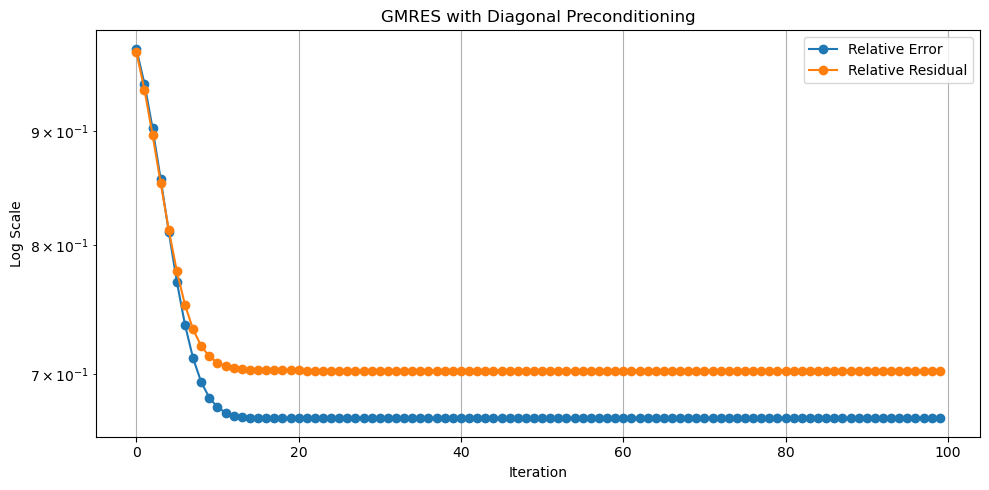

In [11]:
n = 100
C = np.diag(2 + np.arange(n)) - np.diag(np.ones(n-1), 1) - np.diag(np.ones(n-1), -1)
M = np.diag(np.diag(C))  # 对角预处理矩阵
b = np.ones(n)
x_exact = np.linalg.solve(C, b)

# 使用预处理的GMRES
x_approx, error_list, residual_list = gmres_preconditioned(C, b, M, x_exact, tol=1e-18)

plt.figure(figsize=(10, 5))
plt.semilogy(error_list, marker='o', label='Relative Error')
plt.semilogy(residual_list, marker='o', label='Relative Residual')
plt.xlabel('Iteration')
plt.ylabel('Log Scale')
plt.title('GMRES with Diagonal Preconditioning')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
cond_C = np.linalg.cond(C)
cond_MC = np.linalg.cond(np.linalg.inv(M) @ C)
print(f"Condition number of C: {cond_C}")
print(f"Condition number of M⁻¹C: {cond_MC}")

Condition number of C: 81.14988205949659
Condition number of M⁻¹C: 3.2409851646203016


8. 

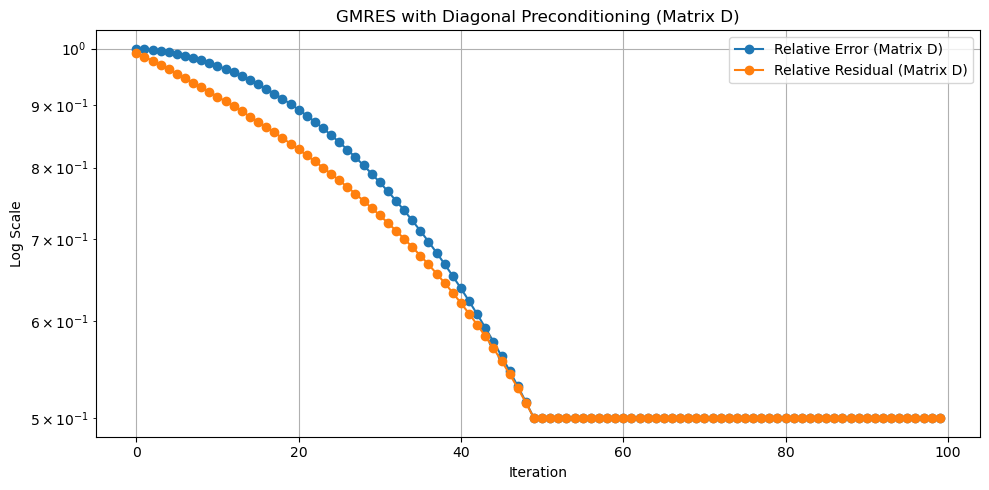

Condition number of D: 4133.642926801396
Condition number of M⁻¹D: 4133.642926801396


In [13]:
n = 100
D = np.diag(2 * np.ones(n)) - np.diag(np.ones(n-1), 1) - np.diag(np.ones(n-1), -1)
M_D = np.diag(np.diag(D))  # 对角预处理矩阵
b = np.ones(n)
x_exact_D = np.linalg.solve(D, b)

# 使用预处理的GMRES
x_approx_D, error_list_D, residual_list_D = gmres_preconditioned(D, b, M_D, x_exact_D, tol=1e-18)

plt.figure(figsize=(10, 5))
plt.semilogy(error_list_D, marker='o', label='Relative Error (Matrix D)')
plt.semilogy(residual_list_D, marker='o', label='Relative Residual (Matrix D)')
plt.xlabel('Iteration')
plt.ylabel('Log Scale')
plt.title('GMRES with Diagonal Preconditioning (Matrix D)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 条件数比较
cond_D = np.linalg.cond(D)
cond_MD = np.linalg.cond(np.linalg.inv(M_D) @ D)
print(f"Condition number of D: {cond_D}")
print(f"Condition number of M⁻¹D: {cond_MD}")

9. 

In [14]:
def conjugate_gradient_precond(A, b, M, x_exact, tol=1e-6, max_iter=None):
    n = len(b)
    x = np.zeros(n)
    r = b - A @ x
    z = M @ r
    d = z.copy()
    error_list = []
    residual_list = []

    res_norm = np.linalg.norm(r)
    initial_res_norm = res_norm
    iter_count = 0
    max_iter = max_iter or n

    while res_norm >= tol * initial_res_norm and iter_count < max_iter:
        iter_count += 1
        Ad = A @ d
        alpha = np.dot(r, z) / np.dot(d, Ad)
        x = x + alpha * d
        r_new = r - alpha * Ad
        z_new = M @ r_new
        
        beta = np.dot(r_new, z_new) / np.dot(r, z)
        d = z_new + beta * d
        
        r = r_new
        z = z_new
        res_norm = np.linalg.norm(r)

        error = np.linalg.norm(x - x_exact) / np.linalg.norm(x_exact)
        error_list.append(error)
        residual_list.append(res_norm / initial_res_norm)

    return x, error_list, residual_list


/tmp/ipykernel_70332/338589375.py:5: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  x_exact_B = spsplin.spsolve(B, b)


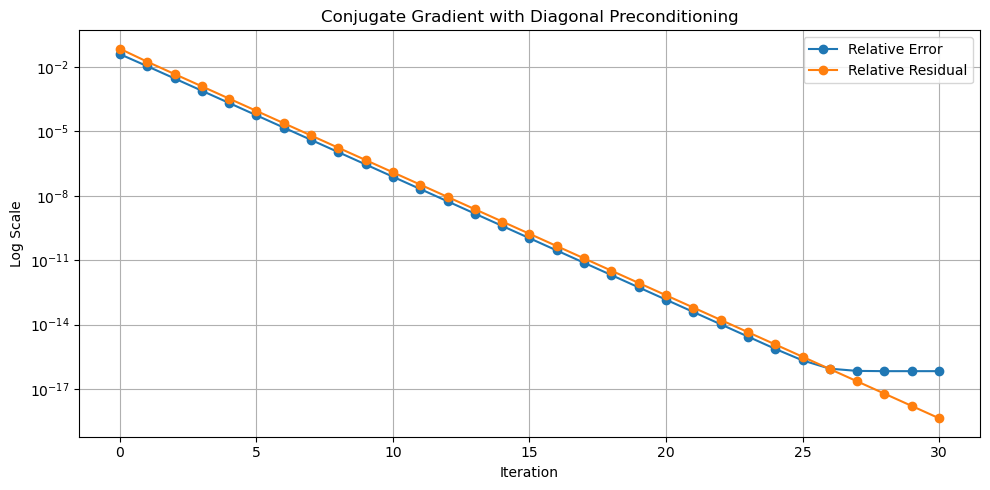

In [15]:
n = 100
B = spsp.diags([[4.]*n, [-1]*(n-1), [-1]*(n-1)], [0, 1, -1])
M_B = spsp.diags([[4.]*n], [0])  # 对角预处理矩阵
b = np.ones(n)
x_exact_B = spsplin.spsolve(B, b)

# 使用预处理的共轭梯度
x_approx_B, error_list_B, residual_list_B = conjugate_gradient_precond(B.toarray(), b, M_B.toarray(), x_exact_B, tol=1e-18)

plt.figure(figsize=(10, 5))
plt.semilogy(error_list_B, marker='o', label='Relative Error')
plt.semilogy(residual_list_B, marker='o', label='Relative Residual')
plt.xlabel('Iteration')
plt.ylabel('Log Scale')
plt.title('Conjugate Gradient with Diagonal Preconditioning')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

10. 

/tmp/ipykernel_70332/2269027928.py:4: SparseEfficiencyWarning: spilu converted its input to CSC format
  ilu = spilu(B)


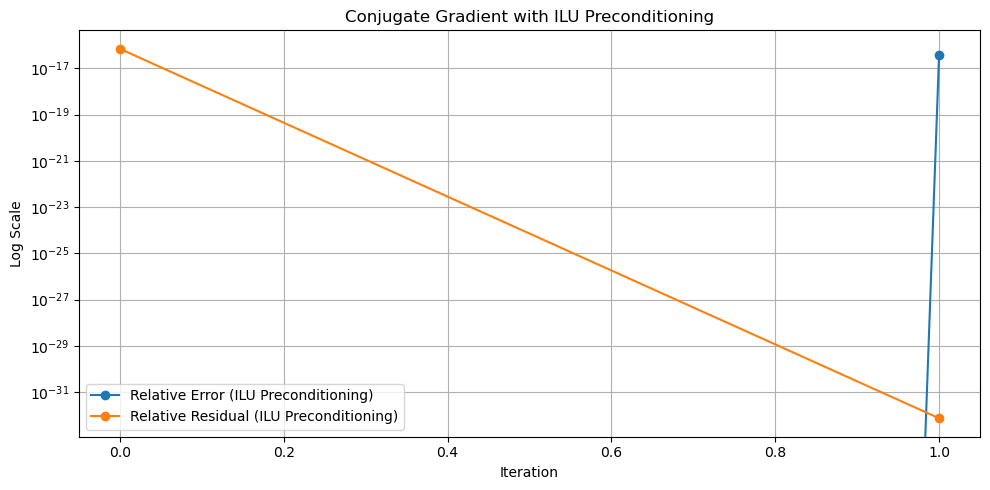

In [16]:
from scipy.sparse.linalg import spilu, LinearOperator

# 使用 ILU 作为预处理器
ilu = spilu(B)
M = LinearOperator(B.shape, matvec=ilu.solve)

# 使用预处理的共轭梯度法
x_approx_B_ILU, error_list_B_ILU, residual_list_B_ILU = conjugate_gradient_precond(B.toarray(), b, M, x_exact_B, tol=1e-18)

plt.figure(figsize=(10, 5))
plt.semilogy(error_list_B_ILU, marker='o', label='Relative Error (ILU Preconditioning)')
plt.semilogy(residual_list_B_ILU, marker='o', label='Relative Residual (ILU Preconditioning)')
plt.xlabel('Iteration')
plt.ylabel('Log Scale')
plt.title('Conjugate Gradient with ILU Preconditioning')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
